In [456]:
using DataFrames #for data wrangling
using StatsPlots #for plotting
using Turing #for MCMC
using CSV #CSV import
using Random #data generation (if required)
using Distributions
using LogExpFunctions #for logistic function

Import Data

In [457]:
#this is a local document, but i've also saved a slightly cleaned up version in github with the same "valveTestRaw" title
valveData = CSV.read("./Results of New Valve Tests.csv", DataFrame)

Row,Vendor,Population,Rejected,High Pop,% Over Set,% Over Limit,Set Pressure,Service
,String1,Int64,Int64,Int64,String7,String7,Int64?,String15
1,a,9,2,1,10.00%,4.30%,35,steam
2,b,13,0,0,0.00%,0.00%,missing,air
3,c,85,1,1,13.00%,9.70%,175,steam
4,d,108,21,4,4.50%,1.50%,350,air
5,e,1,0,0,0.00%,0.00%,missing,na
6,f,55,9,2,5.50%,2.50%,400,liquid
7,g,41,5,2,6.70%,3.30%,165,steam
8,h,2,0,0,0.00%,0.00%,missing,air
9,z,40,6,1,24.00%,20.00%,165,steam


Collect Number of Trials & Separate into Service Mediums

In [ ]:
serviceMediums = ["steam", "air", "liquid", "air/liquid", "na"]
mediumDF = Dict()

for medium in serviceMediums
    mediumDF = merge(Dict(medium => filter(:Service => ==(medium), valveData)), mediumDF)
end

mediumDF["steam"]

Row,Vendor,Population,Rejected,High Pop,% Over Set,% Over Limit,Set Pressure,Service
,String1,Int64,Int64,Int64,String7,String7,Int64?,String15
1,a,9,2,1,10.00%,4.30%,35,steam
2,c,85,1,1,13.00%,9.70%,175,steam
3,g,41,5,2,6.70%,3.30%,165,steam
4,z,40,6,1,24.00%,20.00%,165,steam
5,k,1,0,0,0.00%,0.00%,missing,steam
6,m,14,7,3,10.00%,3.00%,80,steam


Set Up Model

In [459]:
@model function valveTesting(Vendors, Population, rejects) # highpops serviceMedium)
    #additional functionality can be added to this, especially when considering that the probability of failing (p-1) is the sum of the probability of failing on a low pop (less dangerous) & a high pop (more dangerous)      
    
    
    #hyper prior
        μ_bar ~ Normal(-2, 2) #best first guess is that most valves are unlikely to fail, possibly with large spread
        σ ~ Exponential(1) #allow possibility of large std dev in data
    
        μ = Vector{Real}(undef, length(Vendors))

    for i in 1:length(Vendors)
        μ[i] ~ Normal(μ_bar, σ) #assume that the logit(probability) is distributed normally for each vendor
    end

    for i in 1:length(Vendors)
        
        #prior
        n = Population[i] #number of trials for binomial function
        p = logistic(μ[i]) #force p (probability of failure) to be 0<p<1
        #distribution of valves failing given fail probability p and n trials
        rejects[i] ~ Binomial(n, p) #binomial distribution used (most appropriate since measuring probability of failure given trial data)
    end
end

valveTesting (generic function with 2 methods)

In [460]:
model = Dict()
posterior = Dict()
posteriorDF = Dict()
for medium in serviceMediums
  model = merge(Dict(medium => valveTesting(mediumDF[medium][:,1], mediumDF[medium][:,2], mediumDF[medium][:,3])), model)
  posterior = merge(Dict(medium => sample(model["steam"], NUTS(), 1000)), posterior)
  posteriorDF = merge(Dict(medium => DataFrame(posterior[medium])), posteriorDF)
end

Vendor 1 Check (USED FOR DEBUGGING)

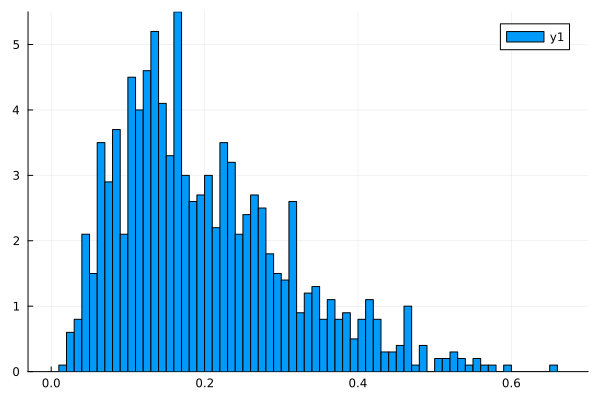

In [461]:
vend1_processed = zeros(nrow(posteriorDF["steam"]))

for i in 1:nrow(steam_postDF)
    vend1_processed[i] = logistic(steam_postDF[i,5]) #recover probability of a valve from this vendor & service medium failing an initial pop test
end

histogram(vend1_processed, normalize=:pdf, bins=101)

Process Steam Medium Data

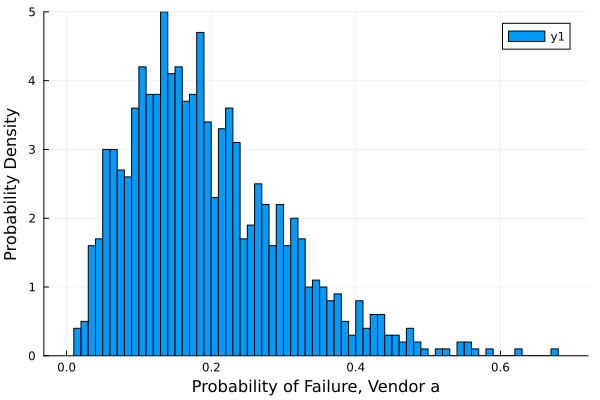

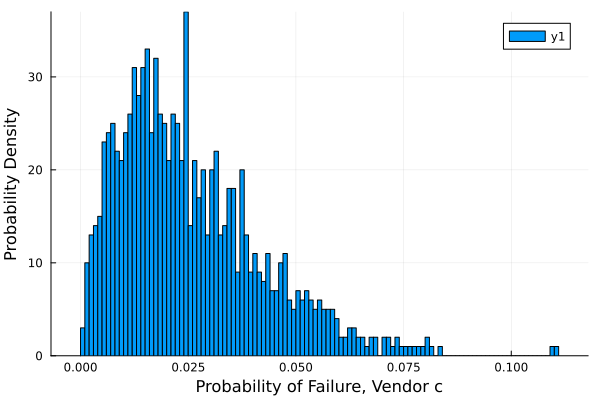

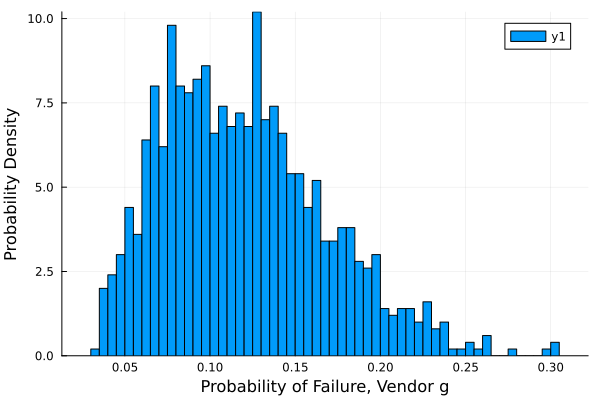

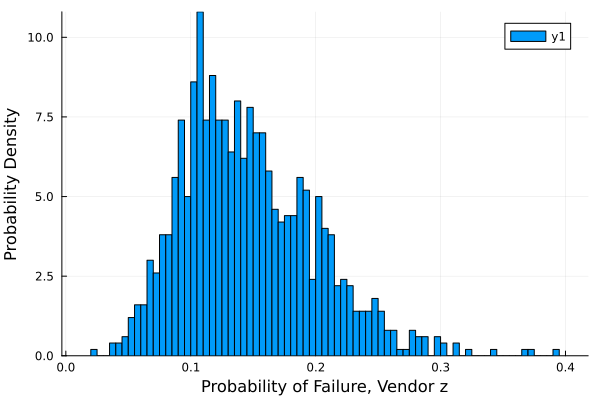

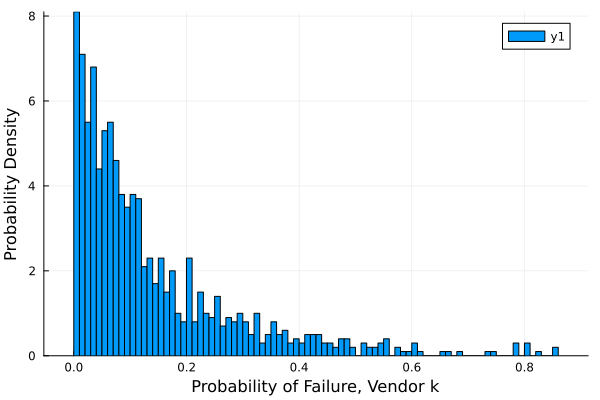

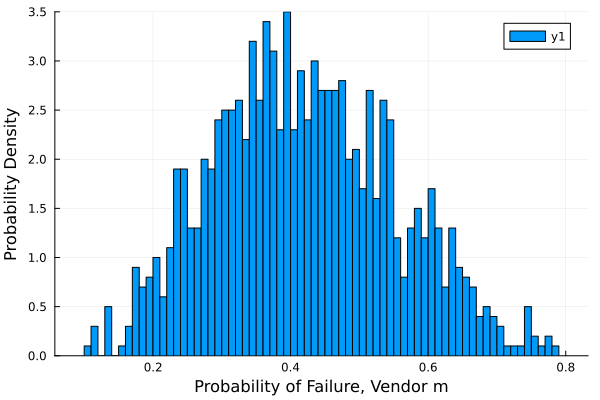

In [462]:
#gather all posterior data into an array, with each column representing a vendor's data
#also make an array of plots for each
steam_processed = zeros(nrow(posteriorDF["steam"]), nrow(mediumDF["steam"]))
steam_plots = Array{Plots.Plot{Plots.GRBackend},1}()

#set array values to match calculated μ values from MCMC
#post-process with logistic function to recover probability of valve failure
for i in 1:nrow(mediumDF["steam"])
    for j in 1:nrow(posteriorDF["steam"])
        steam_processed[j,i] = logistic(posteriorDF["steam"][j, "μ[$i]"])
    end
    #plotter is an intermediate value to gather plot data & incorporate into plot array
    plotter = histogram(steam_processed[:,i], xlab = "Probability of Failure, Vendor " * mediumDF["steam"][i, 1], ylab = "Probability Density", normalize=:pdf, bins=101)
    push!(steam_plots, plotter)
end
#plot all probability plots for the steam medium, grouped by vendor
for z in 1:length(steam_plots)
    display(plot(steam_plots[z]))
end

Predict Valve Failure for Steam Based on Model

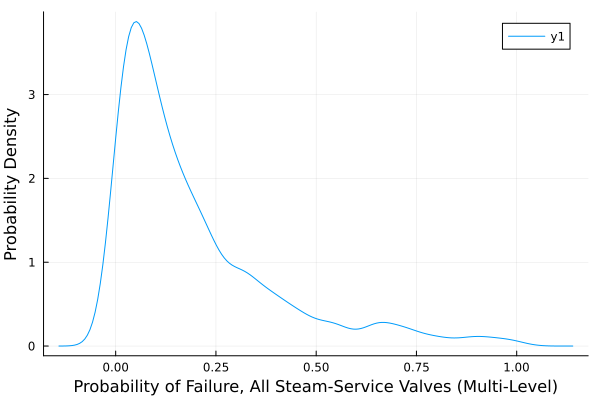

In [463]:
steam_logodds = rand.(Normal.(steam_postDF.μ_bar[1:1000], steam_postDF.σ[1:1000]))
steam_pdf = logistic.(steam_logodds)

predict_plot = plot(xlab="Probability of Failure, All Steam-Service Valves (Multi-Level)", ylab="Probability Density")
density!(steam_pdf)